In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
pd.set_option('max_rows', 20)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 3)
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
AQI_FILEPATH = os.path.join(os.curdir, 'data', 'aqi.csv')

df = pd.read_csv(filepath_or_buffer=AQI_FILEPATH, parse_dates=['datetime'], index_col='datetime', na_values='NR')
df_bak = df.copy()

# 保留降雨量為 NR 值的資料
df_withnr = pd.read_csv(filepath_or_buffer=AQI_FILEPATH, parse_dates=['datetime'], index_col='datetime')
df_withnr_bak = df_withnr.copy()

# 保留還未將 datetime 設為 index 的資料
df_noindex = pd.read_csv(filepath_or_buffer=AQI_FILEPATH)
df_noindex_bak = df_noindex.copy()

# 讀取未處理過的原始資料
AQI_ORIG_FILEPATH = os.path.join(os.curdir, 'data', 'aqi_original.csv')

df_orig = pd.read_csv(AQI_ORIG_FILEPATH)
df_orig_bak = df_orig.copy()

# 讀取還未使用 pivot_table() 處理過的資料
AQI_NOPIVOT_FILEPATH = os.path.join(os.curdir, 'data', 'aqi_nopivot.csv')

df_nopivot = pd.read_csv(AQI_NOPIVOT_FILEPATH, na_values=['NR'])
df_nopivot.replace(r'[-]?\D*[.]?\D*[#*x]+', np.nan, regex=True, inplace=True)
df_nopivot.loc[:, 'value'] = df_nopivot.loc[:, 'value'].astype(np.float64)
df_nopivot_bak = df_orig.copy()

In [4]:
df.head()

,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
datetime,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,20.0,2.0,0.20,0.04,1.7,7.5,9.2,25.0,67.0,18.0,NaN,88.0,1.5,2.0,33.0,37.0,1.4,0.1
2017-01-01 01:00:00,20.0,2.2,0.19,0.05,1.9,7.9,9.8,18.0,52.0,14.0,NaN,88.0,2.1,2.2,76.0,143.0,0.5,0.6
2017-01-01 02:00:00,19.0,2.2,0.24,0.08,2.0,9.3,11.0,13.0,59.0,17.0,NaN,89.0,2.0,2.3,140.0,142.0,0.5,0.6
2017-01-01 03:00:00,19.0,2.4,0.24,0.11,1.4,9.5,11.0,8.5,53.0,24.0,NaN,90.0,1.8,2.5,107.0,51.0,0.5,0.4
2017-01-01 04:00:00,18.0,3.4,0.23,0.12,6.8,11.0,17.0,1.8,37.0,25.0,NaN,90.0,1.7,3.6,96.0,106.0,1.0,0.5


### `pandas.get_dummies()`：One-hot Encoding——將名目尺度資料轉成 dummy/indicator variables

在資料中不一定總是連續型數值，而有可能是名目尺度的資料，這些稱為資料的「狀態」。為了後續的分析需求，我們可以使用 **One-hot Encoding** 技術，將這些狀態各別編碼，將每個狀態放置於獨立的儲存單位。

至於何謂名目尺度的資料呢？舉例如下：

* 性別：`gender = ["male", "female"]`
* 國家：`country = ["Europe", "US", "Asia", "Taiwan"]`
* 瀏覽器名稱：`browser = ["Firefox", "Chrome", "Safari", "Internet Explorer"]`

所以以性別為例，若轉換前的資料為：

index | gender
--- | ---
0 |  male
1 |  female

則轉換後將為：

index | male | female
--- | --- | ---
0 |  1 | 0
1 |  0 | 1

* .get_dummies() : 將 類別 資料轉成 dummy 或 indicator variables
    * 文件連結：[pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    
    * Parameters：
        1. data : array-like, Series, or DataFrame
        1. prefix : 預設為 None，產生新的 dummy variables column label 前面再加上一個名稱
        1. prefix\_sep : 如果有設定 prefix，則 預設為`'_'` ，在 prefix 和 原本的 類別名稱中間加上一個符號
        
    * Returns: DataFrame

In [5]:
# 建立一個測試資料 test
# age : 年齡
# gender : 性別
# hight : 身高
# country : 國家

test = pd.DataFrame({"age":[23, 35, 29, 45, 30, 41], 
                     "gender":['female', 'male', 'female','male', 'male', 'female'], 
                     "hight":[158.5, 175.6, 160.3, 170.5, 172.5, 168.0],
                     "country":['Taiwan', 'Taiwan', 'Japan', 'China', 'Korea', np.nan]
                    })
display(test)

print('===================================')

# 將 國家 (column= country) 改成 one-hot-encoding，再與原本的 test 合併，並刪除 國家(column= country) 欄位

# step1. 使用 pandas.get_dummies() 產生 country 的 dummy variable

# 補充說明：設定 prefix 的差異
display(pd.get_dummies(test['country'], prefix='country', prefix_sep='_'))
display(pd.get_dummies(test['country']))

country_dummy = pd.get_dummies(test['country'], prefix='country', prefix_sep='_')

print('===================================')

# step2. 使用 pandas.concat() (在 chpater 6 的 concat()：根據座標軸來結合資料) 與原本的 test 合併
test = pd.concat([test, country_dummy], axis=1)
display(test)

print('===================================')

# step3. 使用 pandas.DataFrame.drop() (在 chpater 4 的 4.1 Modify DataFrame) 刪除 國家(column= country) 欄位
test = test.drop(columns='country')
display(test)

,age,gender,hight,country
0,23,female,158.5,Taiwan
1,35,male,175.6,Taiwan
2,29,female,160.3,Japan
3,45,male,170.5,China
4,30,male,172.5,Korea
5,41,female,168.0,NaN


,country_China,country_Japan,country_Korea,country_Taiwan
0,0,0,0,1
1,0,0,0,1
2,0,1,0,0
3,1,0,0,0
4,0,0,1,0
5,0,0,0,0


,China,Japan,Korea,Taiwan
0,0,0,0,1
1,0,0,0,1
2,0,1,0,0
3,1,0,0,0
4,0,0,1,0
5,0,0,0,0


,age,gender,hight,country,country_China,country_Japan,country_Korea,country_Taiwan
0,23,female,158.5,Taiwan,0,0,0,1
1,35,male,175.6,Taiwan,0,0,0,1
2,29,female,160.3,Japan,0,1,0,0
3,45,male,170.5,China,1,0,0,0
4,30,male,172.5,Korea,0,0,1,0
5,41,female,168.0,NaN,0,0,0,0


,age,gender,hight,country_China,country_Japan,country_Korea,country_Taiwan
0,23,female,158.5,0,0,0,1
1,35,male,175.6,0,0,0,1
2,29,female,160.3,0,1,0,0
3,45,male,170.5,1,0,0,0
4,30,male,172.5,0,0,1,0
5,41,female,168.0,0,0,0,0


### `.rolling()`：計算移動平均
* 可處理移動平均（moving average，MA），又稱「移動平均線」簡稱均線，是技術分析中一種分析時間序列數據的方法。 

* 最常見的是利用股價、回報或交易量等變數計算出移動平均。 

* 移動平均可撫平短期波動，反映出長期趨勢或周期。

* .rolling() + .mean() 
    * 文件連結：[pandas.DataFrame.rolling](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html#pandas.DataFrame.rolling)
    * Parameters ：
        1. window : 移動的大小
        1. min_periods : 
        1. center : 
            * True : 以當前這筆數值為中心，取附近(window)的數值進行計算
                * 奇數：例如 window=5，則 `(5-1)/2` ，所以以當前這筆數值為中心取前後兩筆共 5 筆進行計算
                * 偶數：例如 window=4，則 以當前這筆數值為中心，往前取 2 筆，往後取 1 筆，共 4 筆進行計算
            * False : 以當前這筆數值(含)往前取(window)的數值進行計算
    * .mean()：設定計算的方法為平均，亦可設定其他統計量
        


,AMB_TEMP,AMB_TEMP_rolling_1,AMB_TEMP_rolling_2,AMB_TEMP_rolling_3
datetime,,,,
2017-01-01 00:00:00,20.0,NaN,NaN,19.666667
2017-01-01 01:00:00,20.0,NaN,20.000000,19.500000
2017-01-01 02:00:00,19.0,NaN,19.666667,19.200000
2017-01-01 03:00:00,19.0,NaN,19.500000,18.600000
2017-01-01 04:00:00,18.0,19.2,19.200000,18.200000
2017-01-01 05:00:00,17.0,18.6,18.600000,18.000000
2017-01-01 06:00:00,18.0,18.2,18.200000,18.000000
2017-01-01 07:00:00,18.0,18.0,18.000000,18.400000
2017-01-01 08:00:00,19.0,18.0,18.000000,19.400000


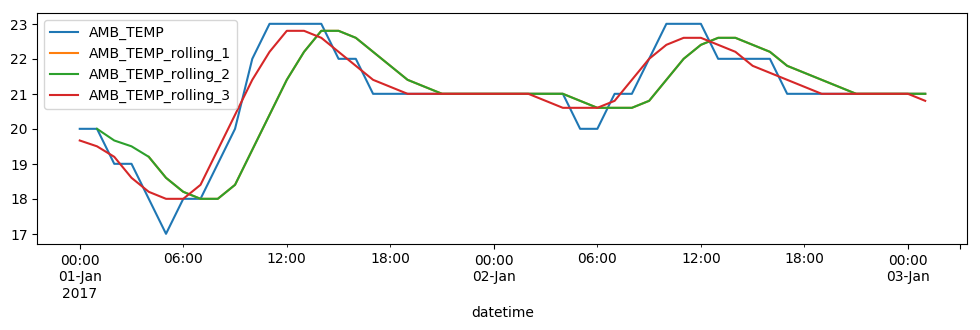

In [6]:
df_part = df.loc['2017-01-01 00:00:00':'2017-02-01 00:00:00', ['AMB_TEMP']].copy()

# 說明 rolling 的效果：

# 第 1 種參數設定：
# window=4 : 取前 4 筆
# min_periods=None : 不足三筆者，補值 NaN
# center=False : 不要平移
# .mean() : 前 4 筆的平均值

df_part['AMB_TEMP_rolling_1'] = df_part['AMB_TEMP'].rolling(window=5, min_periods=None, center=False).mean()

# 第 2 種參數設定：
# window=4 : 取前 4 筆
# min_periods=2 : 不足 2 筆，補值 NaN。足 2 不足 4 筆者則以可以取得的筆數進行運算。
# center=False : 不要平移
# .mean() : 前 4 筆的平均值

df_part['AMB_TEMP_rolling_2'] = df_part['AMB_TEMP'].rolling(window=5, min_periods=2, center=False).mean()

# 第 3 種參數設定：
# window=4 : 取前 4 筆
# min_periods=2 : 不足 2 筆，補值 NaN。足 2 不足 4 筆者則以可以取得的筆數進行運算。
# center=True : 平移
# .mean() : 前 4 筆的平均值

df_part['AMB_TEMP_rolling_3'] = df_part['AMB_TEMP'].rolling(window=5, min_periods=2, center=True).mean()

display(df_part.head(10))

df_part.head(50)[['AMB_TEMP', 'AMB_TEMP_rolling_1', 'AMB_TEMP_rolling_2', 'AMB_TEMP_rolling_3']].plot(kind='line')
plt.show()



### `.shift()` : 資料平移

* 文件連結：[pandas.DataFrame.shift](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html#pandas.DataFrame.shift)
* Parameters：
        1. periods : 輸入欲平移的數值，數值可正或負


In [7]:
test = pd.DataFrame({"A":[10, 10, 11, 9, 11.5], 
                   "B":[5.5, 5.5, 5, 6.2, 5.8], 
                   "C":[190, 200, 230, 260, 235]},
                    index= pd.date_range('2018-01-01 00:00:00', freq='h', periods=5)
                   )
display(test)

print('===================================================')

test_shift = test.shift(periods=2)
test_shift.columns = [ x + '_t-2' for x in test.columns ]
display(test_shift)

print('===================================================')

test = pd.concat([test, test_shift], axis=1)
display(test)

,A,B,C
2018-01-01 00:00:00,10.0,5.5,190
2018-01-01 01:00:00,10.0,5.5,200
2018-01-01 02:00:00,11.0,5.0,230
2018-01-01 03:00:00,9.0,6.2,260
2018-01-01 04:00:00,11.5,5.8,235


,A_t-2,B_t-2,C_t-2
2018-01-01 00:00:00,NaN,NaN,NaN
2018-01-01 01:00:00,NaN,NaN,NaN
2018-01-01 02:00:00,10.0,5.5,190.0
2018-01-01 03:00:00,10.0,5.5,200.0
2018-01-01 04:00:00,11.0,5.0,230.0


,A,B,C,A_t-2,B_t-2,C_t-2
2018-01-01 00:00:00,10.0,5.5,190,NaN,NaN,NaN
2018-01-01 01:00:00,10.0,5.5,200,NaN,NaN,NaN
2018-01-01 02:00:00,11.0,5.0,230,10.0,5.5,190.0
2018-01-01 03:00:00,9.0,6.2,260,10.0,5.5,200.0
2018-01-01 04:00:00,11.5,5.8,235,11.0,5.0,230.0


### `.diff()` : 計算資料差值

* 文件連結：[pandas.DataFrame.diff](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shift.html#pandas.DataFrame.diff)
* Parameters：
        1. periods : 輸入欲平移計算的範圍，數值可正或負

In [8]:
df = pd.DataFrame({'a': [1, 2, 3, 4, 5, 6],
                   'b': [1, 1, 2, 3, 5, 8],
                   'c': [1, 4, 9, 16, 25, 36]})

df.diff(2)

,a,b,c
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,2.0,1.0,8.0
3,2.0,2.0,12.0
4,2.0,3.0,16.0
5,2.0,5.0,20.0
